<a href="https://colab.research.google.com/github/SalNel97/qmss_python_hw4/blob/main/sne2114_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**QMSS S5073**
# ***Homework 4***
**Salah El-Sadek (sne2114)**

---

##**Part 1**

In [1]:
# !pip install tensorflow

In [2]:
%matplotlib inline

import warnings
warnings.simplefilter("ignore", UserWarning)

# Importing relevant libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

#import tensorflow
#tensorflow.random.set_seed(seed)

np.random.seed(2)

*In part one of the homework, you will solve a text classification task.*

*You can download the following data-sets from the HW data folder on the course website:*

*HW4_Text_train_data.csv and HW4_text_test_data.csv*

*The data consists of Women’s fashion online shop reviews, consisting of a review
text, and whether the review author would recommend the product.*

*We are trying to determine whether a reviewer will recommend a product or not based on each review.*

*In a real application this might allow us to find out what is good or bad about certain products or to feature more typical reviews (like a very critical and a very positive one).*

In [3]:
#Reading in data
from google.colab import drive
drive.mount('/content/drive')

train_df = pd.read_csv('/content/drive/MyDrive/Python/Homeworks/HW4_Text_train_data.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Python/Homeworks/HW4_Text_test_data.csv')

train_df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Review,Recommended
0,"""go to"" please offer a maxi for mature custome...",1
1,"""go to"" tee for sz 10+ women.Women who want so...",1
2,"""long and warm"".These leg warmers are perfect ...",1
3,"""tweed"" dress.I bought this dress for my siste...",1
4,#1 stunna.I am in lust with this fabulous dres...,1
...,...,...
16980,Zipper is weird.I ordered the dress on-line. t...,0
16981,Zipper?.Like the other reviewers i was disappo...,0
16982,"Zippery-do-dah, zippery-day, my,oh,my sweater....",1
16983,Zoe slip.When i saw this slip/nighty on-line i...,1


In [4]:
test_df

,Review,Recommended
0,"""beach business"".Great for the beachy business...",1
1,"""formal pajamas"".These are super comfy and so ...",1
2,"""perfect with jeans"".Great with leggings.perfe...",1
3,"""won't stretch"" tags are misleading.The tag on...",1
4,$200 piece of polyester.A $200 piece of polyes...,0
...,...,...
5652,Your classic plaid blazer w/ patch elbows.I ha...,1
5653,Yuck.I love jumpsuits - except for this one. t...,0
5654,"Yuck.This looked beautiful online, but the ski...",0
5655,Zip hoodie not a pullover.This hoodie is reall...,1


**Separating the reviews from the recommendation in both train and test dataframes.**

In [5]:
X_train = np.array(train_df['Review'])
y_train = np.array(train_df['Recommended'])

X_test = np.array(test_df['Review'])
y_test = np.array(test_df['Recommended'])

X_train.shape


(16985,)

In [6]:
y_train.shape

(16985,)

In [7]:
X_test.shape

(5657,)

In [8]:
y_test.shape

(5657,)

*Use cross-validation to evaluate the results. Use a metric that’s appropriate for imbalanced classification (AUC or average precision for example), and inspect all models by visualizing the coefficients.*

*To complete part one of the homework do the following:*

*Import the text data, vectorize the review column into an X matrix.  Then run at least three models and select a single best model.  Note that you can also create three models that simply use different types of explanatory variables such as a logistic regression with different n grams or different tokenizers.  Be sure to explain your choice and evaluate this model using the test set.*

###**Logistic Regression with vectorization eliminating common English stop words and any words not in at least 10 documents (reviews).**

**Given size of dataset, eliminating potentially irrelevant stop words might be more cost effective.**

In [9]:
vect1 = CountVectorizer(min_df = 10, stop_words = "english").fit(X_train)
X1_train = vect1.transform(X_train)
X1_test = vect1.transform(X_test)

print("X with stop words:\n{}".format(repr(X1_train)))
X1_train.shape

X with stop words:
<16985x2870 sparse matrix of type '<class 'numpy.int64'>'
	with 397299 stored elements in Compressed Sparse Row format>


(16985, 2870)

In [10]:
X1_test.shape

(5657, 2870)

In [11]:
from sklearn.metrics import f1_score, make_scorer

f1_scorer = make_scorer(f1_score)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring = f1_scorer)

grid.fit(X1_train, y_train)
print("Best Cross-Val Score : {:.3f}".format(grid.best_score_))
print("Best Parameters: {}".format(grid.best_params_))
print("Testing CV Score (test): {:.3f}".format(grid.score(X1_test, y_test)))

Best Cross-Val Score : 0.937
Best Parameters: {'C': 0.1}
Testing CV Score (test): 0.937


**Using a premade function to help us visualize our coefficients and which words seem most important.**

In [12]:
# helper function to plot top positive and negative coefficients

def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    """Visualize coefficients of a linear model.
    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.
    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.
    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ['#ff2020' if c < 0 else '#0000aa'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")


**Now we visualize**

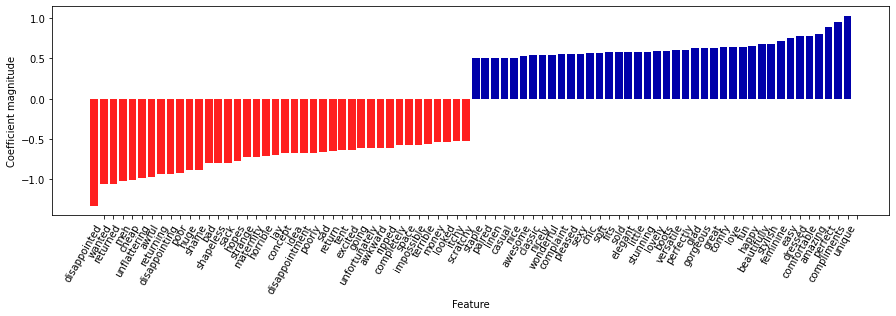

In [13]:
coefs1 = LogisticRegression(C = 0.1).fit(X1_train, y_train).coef_
feature_names1 = vect1.get_feature_names()

visualize_coefficients(coefs1, feature_names1, n_top_features = 40)

###**Logistic Regression with vectorization including n-grams.**

**Including unigrams, bigrams, and trigrams, along with the restriction that each 'gram' needs to be in at least 10 documents (reviews). Including potentially 4-grams in hopes of catching apostrophy words and to be more robust.**

In [14]:
vect2 = CountVectorizer(ngram_range=(1, 4), min_df = 10).fit(X_train)
X2_train = vect2.transform(X_train)
X2_test = vect2.transform(X_test)

print("X with uni-, bi-, and tri- grams:\n{}".format(repr(X2_train)))
X2_train.shape

X with uni-, bi-, and tri- grams:
<16985x27494 sparse matrix of type '<class 'numpy.int64'>'
	with 1641283 stored elements in Compressed Sparse Row format>


(16985, 27494)

In [15]:
grid.fit(X2_train, y_train)
print("Best Cross-Val Score : {:.3f}".format(grid.best_score_))
print("Best Parameters: {}".format(grid.best_params_))
print("Testing CV Score (test): {:.3f}".format(grid.score(X2_test, y_test)))

Best Cross-Val Score : 0.943
Best Parameters: {'C': 0.1}
Testing CV Score (test): 0.946


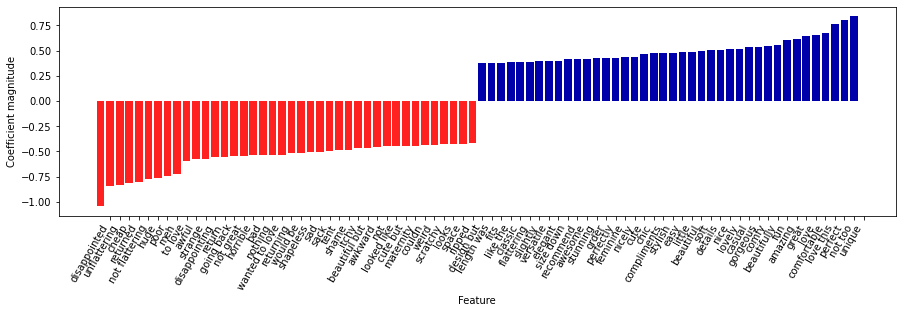

In [16]:
coefs2 = LogisticRegression(C = 0.1).fit(X2_train, y_train).coef_
feature_names2 = vect2.get_feature_names()

visualize_coefficients(coefs2, feature_names2, n_top_features = 40)

###**Logistic Regression with tf-idf vectorization**

**Including unigrams, bigrams, and trigrams, along with the restriction that each 'gram' needs to be in at least 10 documents (reviews).**

**Running tf-idf vectorization in case there are certain uncommon words that are strong predictors of recommendation status (0 or 1).**

In [17]:
vect3 = TfidfVectorizer(ngram_range=(1, 4), min_df = 10, norm = None).fit(X_train)
X3_train = vect3.transform(X_train)
X3_test = vect3.transform(X_test)

print("X with tf-idf vectorization:\n{}".format(repr(X3_train)))
X3_train.shape

X with tf-idf vectorization:
<16985x27494 sparse matrix of type '<class 'numpy.float64'>'
	with 1641283 stored elements in Compressed Sparse Row format>


(16985, 27494)

In [18]:
grid.fit(X3_train, y_train)
print("Best Cross-Val Score : {:.3f}".format(grid.best_score_))
print("Best Parameters: {}".format(grid.best_params_))
print("Testing CV Score (test): {:.3f}".format(grid.score(X3_test, y_test)))

Best Cross-Val Score : 0.942
Best Parameters: {'C': 0.01}
Testing CV Score (test): 0.945


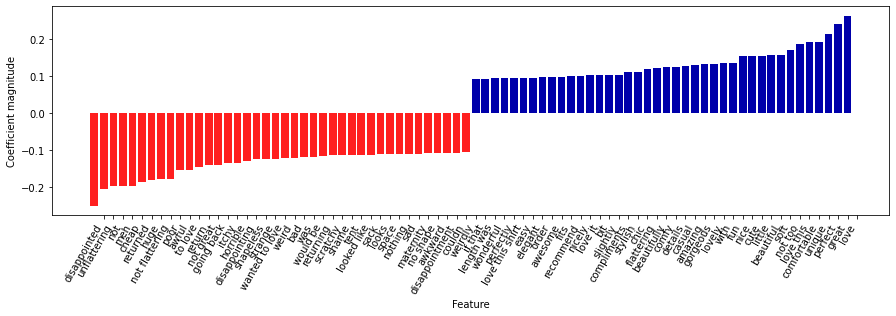

In [19]:
coefs3 = LogisticRegression(C = 0.01).fit(X3_train, y_train).coef_
feature_names3 = vect3.get_feature_names()

visualize_coefficients(coefs3, feature_names3, n_top_features = 40)

**All of our L2 penalized logistic regression models with varying parameters and vectorizations yielded extremely similar results. Our model when excluding common English stop words was the lowest scoring of the 3 models in terms of its f1 score. The count vectorizer model and the tf-idf vectorizer models were extremely similar to one another in their f1 scores (both including up to 4-grams). However, the count vectorizer model was slightly a better predictor model so that is the model I'm choosing.**

**Words like 'hate', 'cheap', and 'disappointed' are expectedly associated with no positive recommendation (= 0). While words like 'love', 'great', 'unique', and 'comfy, were expectedly associated with a positive review and a recommendation (= 1).**

##**Part 2**

*To complete part two of the homework do the following:*

*Run a multilayer perceptron (feed forward neural network) with two hidden layers on the iris dataset using the keras Sequential interface.*

*Data can be imported via the following link:*

http://vincentarelbundock.github.io/Rdatasets/csv/datasets/iris.csv

*Include code for selecting the number of hidden units using GridSearchCV and evaluation on a test-set.  Describe the differences in the predictive accuracy of models with different numbers of hidden units.  Describe the predictive strength of your best model.  Be sure to explain your choice and evaluate this model using the test set.*

In [20]:
np.random.seed(2)

df = pd.read_csv("http://vincentarelbundock.github.io/Rdatasets/csv/datasets/iris.csv")
df = df.iloc[:,1:]

df.Species = pd.Categorical(df.Species)
df['Spec_code'] = df.Species.cat.codes
df

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species,Spec_code
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,2
146,6.3,2.5,5.0,1.9,virginica,2
147,6.5,3.0,5.2,2.0,virginica,2
148,6.2,3.4,5.4,2.3,virginica,2


In [21]:
df.dtypes

Sepal.Length     float64
Sepal.Width      float64
Petal.Length     float64
Petal.Width      float64
Species         category
Spec_code           int8
dtype: object

**Using keras categorization function to do what OneHotEncoder would have essentially done to our 3 category vriable (flower species).**

In [22]:
yb = keras.utils.to_categorical(df['Spec_code'])

print(yb.shape)
yb[:10, :]

(150, 3)


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [23]:
Xb = df.loc[:, df.columns != 'Species']
Xb = Xb.loc[:, Xb.columns != 'Spec_code']

print(Xb.shape)
Xb

(150, 4)


,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


**Just applying imputation and standard scaling to our numeric predictor variables (sepal length, sepal width, petal length, and petal width).**

In [24]:
# Preprocess data using sklearn's Column Transformer approach

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = ['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

In [25]:
preprocess.fit(Xb)

X_pro = preprocess.transform(Xb)

print(X_pro.shape)

(150, 4)


**Train-test split data**

In [26]:
Xp_train, Xp_test, yp_train, yp_test = train_test_split(X_pro, yb)

**We create a Keras Classifier function so we could run it through GridSearchCV to find best value for our parameter 'number of nodes in hidden layer'.**

In [27]:
from numpy.random import seed
seed(1)

import tensorflow
tensorflow.random.set_seed(2)

# Creating KerasClassifier function
def create_model(hiddennodes=1):
  model = Sequential() 
  model.add(Dense(hiddennodes, activation = 'relu', input_dim = 4)) # Four X features
  model.add(Dense(units = 30, activation = 'relu'))
  model.add(Dense(units = 3, activation = 'softmax')) # Softmax for more than two categories
  # Compile
  model.compile(loss='categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model, epochs=100, verbose=0)

param_grid2 = dict(hiddennodes=[16, 32, 64, 128])
grid2 = GridSearchCV(estimator=model, param_grid=param_grid2)

grid2.fit(Xp_train, yp_train)
print("Best Cross-Val Score : {:.3f}".format(grid2.best_score_))
print("Best Parameters: {}".format(grid2.best_params_))
print("Testing CV Score (test): {:.3f}".format(grid2.score(Xp_test, yp_test)))

Best Cross-Val Score : 0.866
Best Parameters: {'hiddennodes': 32}
Testing CV Score (test): 0.921


In [28]:
res = pd.DataFrame(grid2.cv_results_)
res.pivot_table(index=["param_hiddennodes"],
values=["mean_test_score"])

,mean_test_score
param_hiddennodes,
16,0.839130
32,0.866008
64,0.848221
128,0.848221


**It seems that the ideal number of 'neurons' in a hidden layer is 32 according to our CV scores. This makes sense as introducing too many neurons per hidden layer may add bias and 'overfit' our model without contributing much to prediction power. Test score on the 32 neuron per layer value was 0.921, indicating pretty strong predictive capabilities using a neural network of not more than 32 neurons per hidden layer (of 2 total hidden layers).**